# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=100,
                       initial_x = [0.2, 0.8], 
                       file_name="Turing_sequential_samples",  
                       dialog=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  14%|████▉                              |  ETA: 0:00:01

Burn in step: 2000
eps --->0.025241315587859966
L   --->0.007643689801034896
 
Burn in step: 4000
eps --->0.029348926212972703
L   --->0.010929676015201053
 
Burn in step: 6000
eps --->0.02736433274842907
L   --->0.010036645205171852
 
Burn in step: 8000
eps --->0.021876452008982073
L   --->0.007390628306329498
 


Burn in step: 10000
eps --->0.031215868840670027
L   --->0.005566251986830928
 


[ Info: eps: 0.031215868840670027
[ Info: L: 0.005566251986830928
[ Info: nu: 48.28055648162478
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:05

100000-element Vector{Any}:
 [0.19106268089104103, 0.9344356021191289, 0.031215868840670027, -0.4055626751249637, 15.63326039696207]
 [0.1871710725743617, 0.9354648942541001, 0.03135459063967758, -0.013107422267422564, 15.665130802131273]
 [0.1886298520455496, 0.9063911058479055, 0.03129562824105063, 1.1281720854188269, 16.099990081556186]
 [0.19160746457310576, 0.9267171704854505, 0.031439721552554464, -0.5841595785699596, 15.810265187890947]
 [0.19144726164129292, 0.9581310394064076, 0.030102347254880892, -2.895008998713534, 14.812063739476693]
 [0.19506817927287512, 0.948929583278575, 0.03029073427849342, 0.2795547622453398, 15.068252734524386]
 [0.19676665797742096, 0.9217340152424923, 0.029910543885317917, 1.7073336484285484, 15.855351191652343]
 [0.1934217004245692, 0.9075495261157006, 0.030076563606809627, 0.44369726239998464, 16.103100961412576]
 [0.1902776124556603, 0.9242808942778721, 0.030239948372500526, -0.46230045340224635, 15.87297004760606]
 [0.1903207893727708, 0.95451

In [9]:
std(samples_mchmc)[1:end-2]

3-element Vector{Float64}:
 0.04430801669120408
 0.04503865152435727
 0.004288716119883281

In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

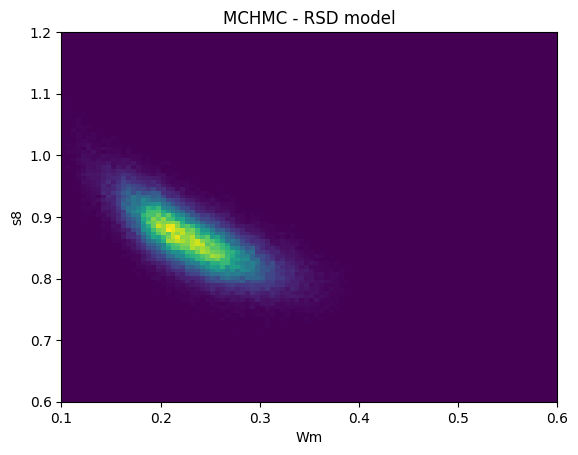

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

##  AbstractMCMC

In [12]:
spl = MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2))
samples = sample(stat_model, spl, 10_000; dialog=true, progress=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  18%|██████▎                            |  ETA: 0:00:00

Burn in step: 2000
eps --->0.03918429411199987
L   --->0.01192126948469395
 


MCHMC (tuning):  36%|████████████▋                      |  ETA: 0:00:00

Burn in step: 4000
eps --->0.019046763199683615
L   --->0.006797124622512787
 


MCHMC (tuning):  55%|███████████████████▏               |  ETA: 0:00:00

Burn in step: 6000
eps --->0.029104096445450298
L   --->0.010513465820943306
 


MCHMC (tuning):  72%|█████████████████████████▍         |  ETA: 0:00:00

Burn in step: 8000
eps --->0.027254598291429507
L   --->0.009133913894798614
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00

Burn in step: 10000
eps --->0.03365964974001195
L   --->0.005355361977089541
 


[ Info: eps: 0.03365964974001195
[ Info: L: 0.005355361977089541
[ Info: nu: 28.169513797677922
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×5×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.69 seconds
Compute duration  = 1.69 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2215    0.0359     0.0004    0.0035   25.1571    1.3138      ⋯
          σ8    0.8704    0.0391     0.0004    0.0026   51.1305    1.1256      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1669    0.1926    0.2189    0.2441    0.2994
          σ8    0.7936    0.8438    0.8700    0.8974    0.9457


In [13]:
new_samples = sample(stat_model, spl, 1_000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×5×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.36 seconds
Compute duration  = 0.36 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2189    0.0399     0.0013    0.0070    5.2782    1.0551      ⋯
          σ8    0.8763    0.0416     0.0013    0.0057   10.4542    1.0217      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1630    0.1851    0.2111    0.2433    0.3080
          σ8    0.7995    0.8468    0.8756    0.9027    0.9604


## Ensemble AbstractMCMC

In [14]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples = sample(stat_model, spl, 1000; burn_in=100, dialog=true)

LoadError: MethodError: no method matching iterate(::MicroCanonicalHMC.EnsembleState{Float64})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


In [15]:
new_samples = sample(stat_model, spl, 1000; burn_in=100, 
                     resume_from=samples)

[ Info: Starting from previous run


Chains MCMC chain (1000×5×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.3 seconds
Compute duration  = 0.3 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2186    0.0297     0.0009    0.0052    5.2286    1.1507      ⋯
          σ8    0.8742    0.0346     0.0011    0.0040   16.0303    1.0534      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1838    0.1945    0.2122    0.2312    0.2842
          σ8    0.8037    0.8503    0.8762    0.8984    0.9396


## Parallelization

In [25]:
samples = sample(
    stat_model, MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2)), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  26%|█████████                          |  ETA: 0:00:01

Burn in step: 2000
eps --->0.04420745850398823
L   --->0.013255360089911763
 
Burn in step: 2000
eps --->0.02295122944826312
L   --->0.006815394775887814
 
Burn in step: 2000
eps --->0.04362189066950644
L   --->0.013034038124029649
 
Burn in step: 2000
eps --->0.018865926552672097
L   --->0.005652351484686067
 


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:01

Burn in step: 4000
eps --->0.03082043801942826
L   --->0.01325878450632089
 
Burn in step: 4000
eps --->0.023606254181844283
L   --->0.00825840861919016
 


MCHMC (tuning):  53%|██████████████████▌                |  ETA: 0:00:00MCHMC (tuning):  58%|████████████████████▏              |  ETA: 0:00:00

Burn in step: 4000
eps --->0.02097039559274118
L   --->0.007576434351987491
 
Burn in step: 4000
eps --->0.025140296649325874
L   --->0.00846428736865028
 


MCHMC (tuning):  72%|█████████████████████████▎         |  ETA: 0:00:00

Burn in step: 6000
eps --->0.027193363684367346
L   --->0.01165371879124601
 
Burn in step: 6000
eps --->0.03220710488531101
L   --->0.011748404011713398
 
Burn in step: 6000
eps --->0.028705632336136603
L   --->0.01141604853330838
 
Burn in step: 6000
eps --->0.0284368845490774
L   --->0.010965763931839442
 


MCHMC (tuning):  86%|██████████████████████████████▎    |  ETA: 0:00:00

Burn in step: 8000
eps --->0.02662441209096795
L   --->0.009821613564462997
 
Burn in step: 8000
Burn in step: 8000
eps --->0.026451083854142323
eps --->0.028256169544901993
L   --->0.009735518125426704
 
L   --->0.010036463511579923
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00

Burn in step: 8000
eps --->0.03157264972388545
L   --->0.01101343998980627
 
Burn in step: 10000
eps --->0.030139355629458145
L   --->0.006293847510892125
 


[ Info: eps: 0.030139355629458145
[ Info: L: 0.006293847510892125
[ Info: nu: 15.195837084921866
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: eps: 0.02539460592538991
[ Info: L: 0.004705678025137751
[ Info: nu: 9.575007469739369
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: eps: 0.02049511404921799
MCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: L: 0.003077467465808778


Burn in step: 10000
eps --->0.02539460592538991
L   --->0.004705678025137751
 
Burn in step: 10000
eps --->0.02049511404921799
L   --->0.003077467465808778
 
Burn in step: 10000
eps --->0.028222870910106498
L   --->0.004634236078912416
 


[ Info: nu: 5.403252885511912
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
[ Info: eps: 0.028222870910106498
[ Info: L: 0.004634236078912416
[ Info: nu: 9.143373957784489
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
chain 4:   3%|█▎                                        |  ETA: 0:00:03

chain 3:   4%|█▌                                        |  ETA: 0:00:03

chain 2:   3%|█▎                                        |  ETA: 0:00:05








chain 3:   6%|██▊                                       |  ETA: 0:00:03

chain 4:   6%|██▌                                       |  ETA: 0:00:04

chain 2:   6%|██▌                                       |  ETA: 0:00:04

chain 1:   8%|███▋                                      |  ETA: 0:00:03
chain 3:  11%|████▋                                     |  ETA: 0:00:03
chain 4:  10%|████▍                                     |  ETA: 0:00:03
chain 2:  10%|████▍                                     |  ETA: 0:00:03
chain 1:  12%|█████▎                       

4-element Vector{Chains}:
 MCMC chain (30000×5×1 Array{Float64, 3})
 MCMC chain (30000×5×1 Array{Float64, 3})
 MCMC chain (30000×5×1 Array{Float64, 3})
 MCMC chain (30000×5×1 Array{Float64, 3})

In [26]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

LoadError: MethodError: no method matching MCHMC(; varE_wanted::Float64)

[0mClosest candidates are:
[0m  MCHMC([91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/ensemble/[39m[90m[4msampler.jl:26[24m[39m
[0m  MCHMC([91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4msampler.jl:53[24m[39m
[0m  MCHMC([91m::Any[39m, [91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/ensemble/[39m[90m[4msampler.jl:8[24m[39m


## NUTS

In [18]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [19]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.0 seconds
Compute duration  = 11.0 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2376    0.0693     0.0007    0.0015   1479.6564    1.0001    ⋯
          σ8    0.8661    0.0629     0.0006    0.0013   2155.7837    1.0003    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [20]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.14131   0.951565  14.9575   7.0  1.0  …  3.0  0.0  0.0509846  0.0509846
 0.131044  0.946093  14.2886   7.0  1.0     2.0  0.0  0.0509846  0.0509846
 0.131732  0.934174  14.1311   3.0  1.0     2.0  0.0  0.0509846  0.0509846
 0.146072  0.940361  15.1291  15.0  1.0     4.0  0.0  0.0509846  0.0509846
 0.211862  0.861762  16.2297  27.0  1.0     4.0  0.0  0.0509846  0.0509846
 0.247328  0.849626  16.2458  23.0  1.0  …  4.0  0.0  0.0509846  0.0509846
 0.257021  0.842653  16.1831  15.0  1.0     3.0  0.0  0.0509846  0.0509846
 0.180773  0.901615  16.0187  23.0  1.0     4.0  0.0  0.0509846  0.0509846
 0.246707  0.82305   15.9929  19.0  1.0 

In [21]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

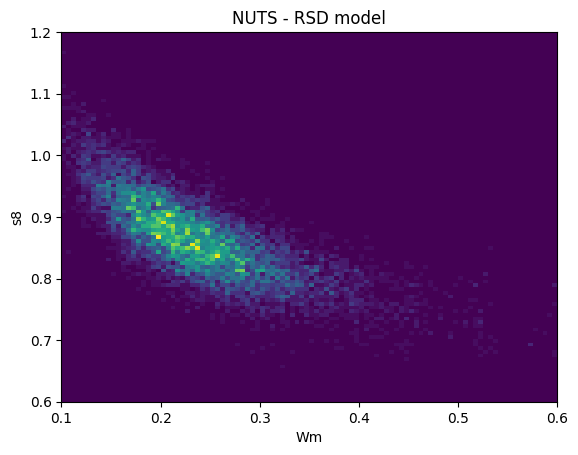

In [22]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");